# Calculate residuals, colocate ICESAT1 points

What i mean by this, is apply a correction to icesat1 points lines so that they lie ontop of each other.  

Method:


Huw said:
You can calculate the residuals from the track*_all_dzdt.mat files in /Users/home/horganhu/ICESAT_LINK/TAMATA_ICESAT/GLA12_633_DZDT/
```
track0099_all_dzdt.mat
dzdt.track0099.bin2963.grad,
dzdt.track0099.bin2963.dzdt,
dzdt.track0099.bin2963.x,
dzdt.track0099.bin2963.y,
dzdt.track0099.bin2963.z,
dzdt.track0099.bin2963.retide,
dzdt.track0099.bin2963.sdatedays,
dzdt.track0099.bin2963.elev_wgs84_tpxtide,
dzdt.track0099.bin2963.lat,
dzdt.track0099.bin2963.lon,
dzdt.track0099.bin2963.ret
```


```matlab
zp = [x-mean(x); y-mean(y)]'*grad + (t-t0)'*(bindzdt) + mean(z); % Note here we use z here (not elev)

zp=zp';

res = z - zp;     % transient changes (footprint elevation changes corrected for
                % slope and secular change. Note here we use z here (not elev)
                
dz=res + ((t - t0).*bindzdt);   % Elevation change corrected for each segment. This is
                % corrected for gradient. Note, this is per day.
```        

1. `zp = [x-mean(x); y-mean(y)]'*grad`  shifts the point up/down an amount dependant on the bin gradient and distance between the point and the bin centre. Ie linear approx of gradient. 
2. `(t-t0)'*(bindzdt)` adds the average background change to the point
3. `mean(z)` sets it to absolute height

- so I think that, zp is essentially corrected height

- res is change between correct height and original height

- dz is change in height over time

In [1]:
import sys
import h5py
import xarray as xr
import glob
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from shapely.ops import nearest_points
import numpy as np
from tqdm import tqdm
from scipy import interpolate

sys.path.append('/Users/home/whitefar/DATA/code/REMOTE_SENSING/ICESAT/')

from icesat1_calculate_residuals import icesat1_load_alldzdt_pickle, icesat1_alldzdt_todataframe



### See more code at
```
/Users/home/whitefar/DATA/code/REMOTE_SENSING/ICESAT/icesat1_calculate_residuals.py
```

1.  I used icesat1_alldzdt_todataframe() to reorganise *_all_dzdt.mat files
2. load the files with icesat1_load_alldzdt_pickle

In [2]:
paths = glob.glob('/Users/home/whitefar/DATA/REMOTE_SENSING/ICESAT1/*_alldzdt.pkl')
tracks = [path[-21:-12] for path in paths]
for track in tracks:
    da = icesat1_load_alldzdt_pickle(track)
    print(track,da.shape)
    del da
    

track1331 (0, 17)
track0141 (0, 17)
track0043 (0, 17)
track1303 (0, 17)
track0057 (0, 17)
track0225 (0, 17)
track0407 (0, 17)
track0169 (0, 17)
track0127 (0, 17)
track0267 (0, 17)
track0365 (0, 17)
track0015 (0, 17)
track0197 (0, 17)
track0001 (0, 17)
track1317 (0, 17)
track0071 (0, 17)
track0309 (0, 17)
track1289 (0, 17)
track0183 (0, 17)
track0029 (0, 17)
track0155 (0, 17)
track0323 (0, 17)
track0351 (0, 17)
track0281 (0, 17)
track0393 (0, 17)
track1275 (0, 17)
track0085 (0, 17)
track0113 (0, 17)
track0295 (0, 17)
track0337 (0, 17)
track0211 (672, 17)
track0099 (1062, 17)
track0379 (0, 17)
track1345 (0, 17)
track0239 (0, 17)
track0253 (0, 17)


In [3]:
def map_track(track,show='zp'):
    da = icesat1_load_alldzdt_pickle(track)
    gd_chan = gpd.read_file("/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/linedownchan.shp")
    plt.figure(figsize=(15,15))
    plt.scatter(da.x,da.y,c=da[show],cmap='Spectral_r')
    plt.plot(gd_chan.iloc[75:-300:10].geometry.x,gd_chan.iloc[75:-300:10].geometry.y,'g:')
    plt.legend(['surface channel low','melt_rate'])
    cb = plt.colorbar()
    cb.set_label(show)
    plt.grid()

In [4]:
def crosssection(track,x_or_y = 'y',show='zp'):
    da = icesat1_load_alldzdt_pickle(track)
    gd_chan = gpd.read_file("/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/linedownchan.shp")
    
    plt.figure(figsize=(15,6))
    for pass_date in da.timestamp.dt.date.unique():
        daa = da[da.timestamp.dt.date==pass_date]
        plt.plot(daa[x_or_y],daa[show],'x',label=pass_date)
    plt.xlim([da[x_or_y].min(),da[x_or_y].max()])
    plt.legend()
    plt.grid()

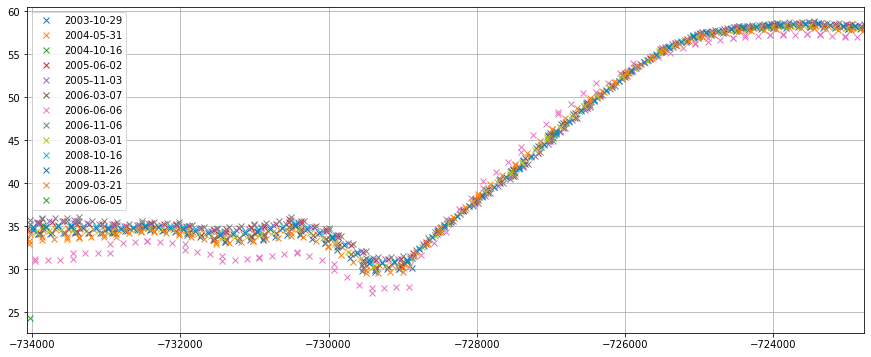

In [5]:
crosssection('track0099',show='zp')

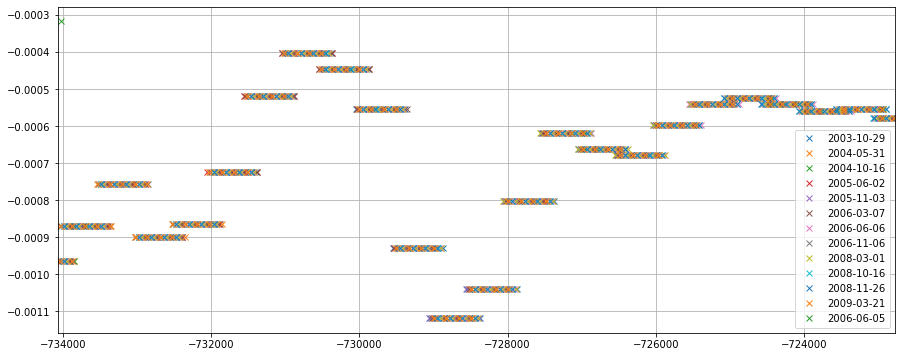

In [6]:
crosssection('track0099',show='dzdt')

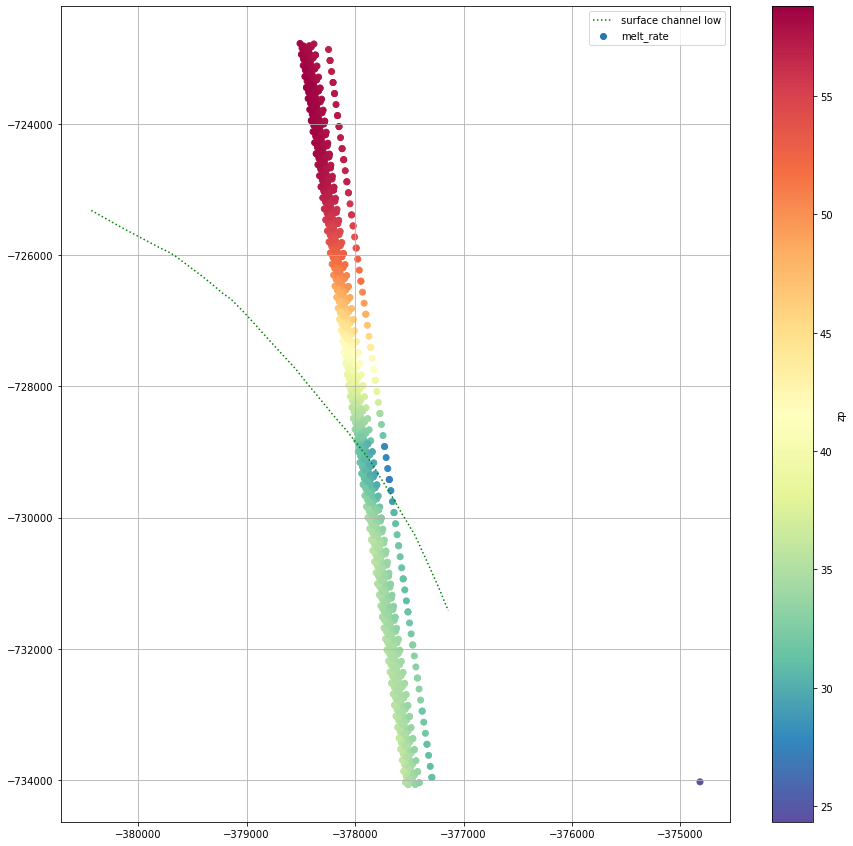

In [7]:
map_track('track0099',show='zp')

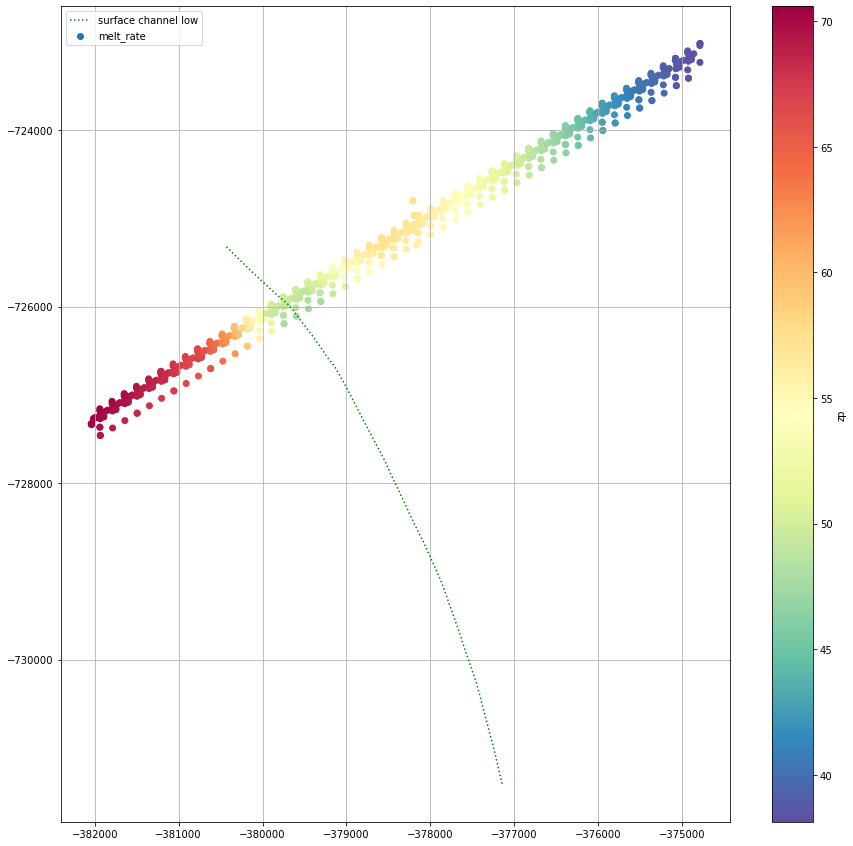

In [10]:
map_track('track0211',show='zp')

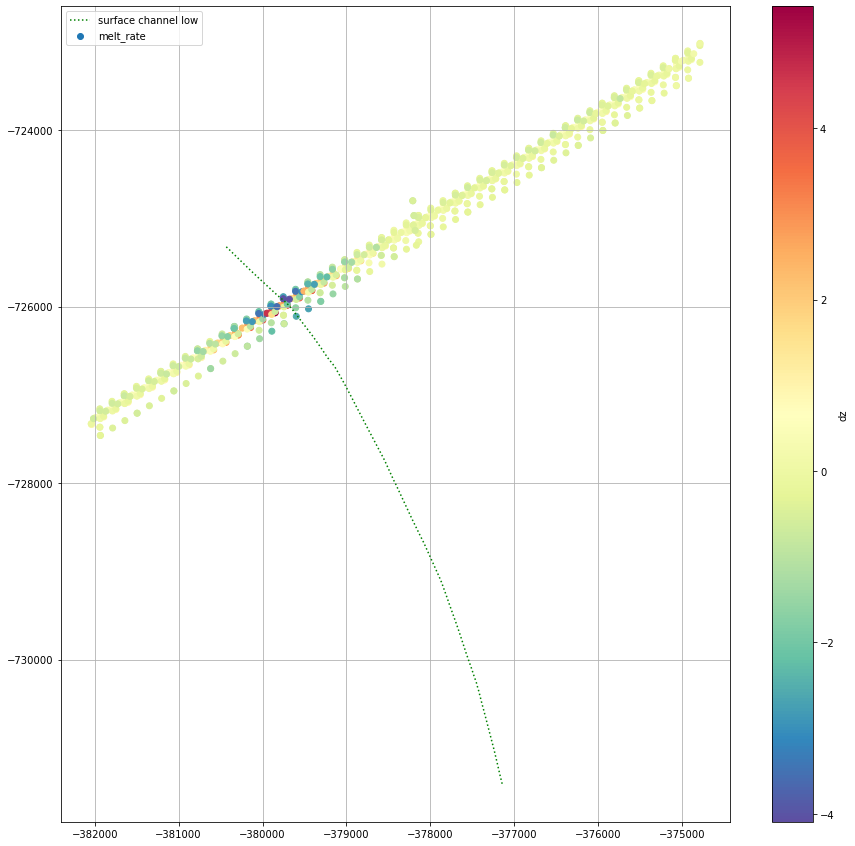

In [11]:
map_track('track0211',show='dz')

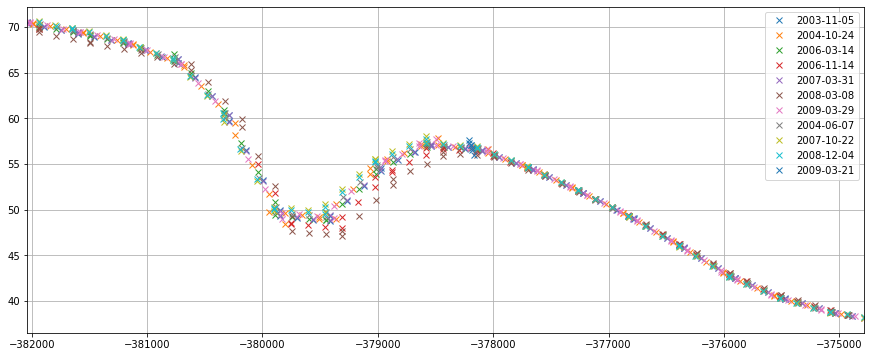

In [12]:
crosssection('track0211',x_or_y = 'x', show='zp')

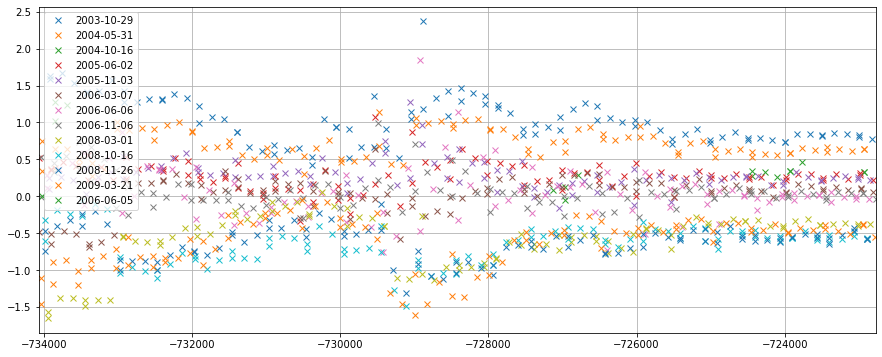

In [13]:
crosssection('track0099',show='dz')

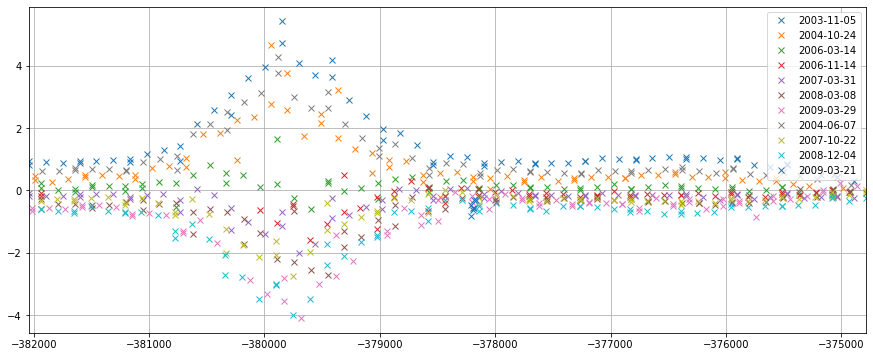

In [14]:
crosssection('track0211',x_or_y='x',show='dz')

# get resonable dzdt for each line

In [63]:
def plot_dzdt_by_line(track, x_or_y = 'x'):

    da = icesat1_load_alldzdt_pickle(track)

    zp_t0 = da[da.timestamp.dt.date==min(da.timestamp.dt.date.unique())].copy()

    dz_dts_rates = [] # change in elevation in m / y
    dates = []
    z_0 = zp_t0.zp.to_numpy() 
    date_0 = zp_t0.timestamp.dt.date.iloc[0]
    
    for pass_date in da.sort_values(['timestamp'],axis=0).timestamp.dt.date.unique()[1:]:

        da_date = da[da.timestamp.dt.date==pass_date].copy() #dataframe restricted to the area, restricted to a cetrain date
        if da_date.shape[0] < len(zp_t0[x_or_y]) - 5:            
            print(f'not enough data for {pass_date}, only {da_date.shape[0]} points')
            continue


        #interpolate so that we can
        f = interpolate.interp1d(da_date[x_or_y], da_date.zp,fill_value="extrapolate")
        z_1 = f(zp_t0[x_or_y])
        date_1 = pass_date

        dz_dts_rates.append( (z_1 - z_0 ) / (date_1 - date_0).days /365.2422 )

        z_0 = z_1.copy()
        date_0 = date_1

        dates.append( pass_date )
        del da_date
        
    fig, ax1 = plt.subplots(figsize=(17,12),dpi=300)
    color = 'tab:blue'
    ax1.set_xlabel('x',fontsize=18)
    ax1.set_ylabel('elevation (m)', color=color,fontsize=18)
    ax1.plot(zp_t0[x_or_y],zp_t0.z,'b-')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid()

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:red'
    ax2.set_ylabel('change in elevation (m/a)', color=color,fontsize=18)
    for date,dz_dt_rate in zip(dates,dz_dts_rates):
        ax2.plot(zp_t0[x_or_y],dz_dt_rate,'x-',label=date)
        if x_or_y == 'x':
            plt.xlim([-382064.5722209641,-374781.1654740692])
        elif x_or_y == 'y':
            plt.xlim([ -734075.0820404041,-722764.4514729496])
    plt.legend()
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.grid()

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title(f'rate of elevation change in m/a between a pass and the previous pass')
    plt.show()


/Users/home/whitefar/miniconda3/envs/remote_sensing/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/home/whitefar/miniconda3/envs/remote_sensing/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in subtract


not enough data for 2006-11-14, only 56 points
not enough data for 2009-03-21, only 7 points


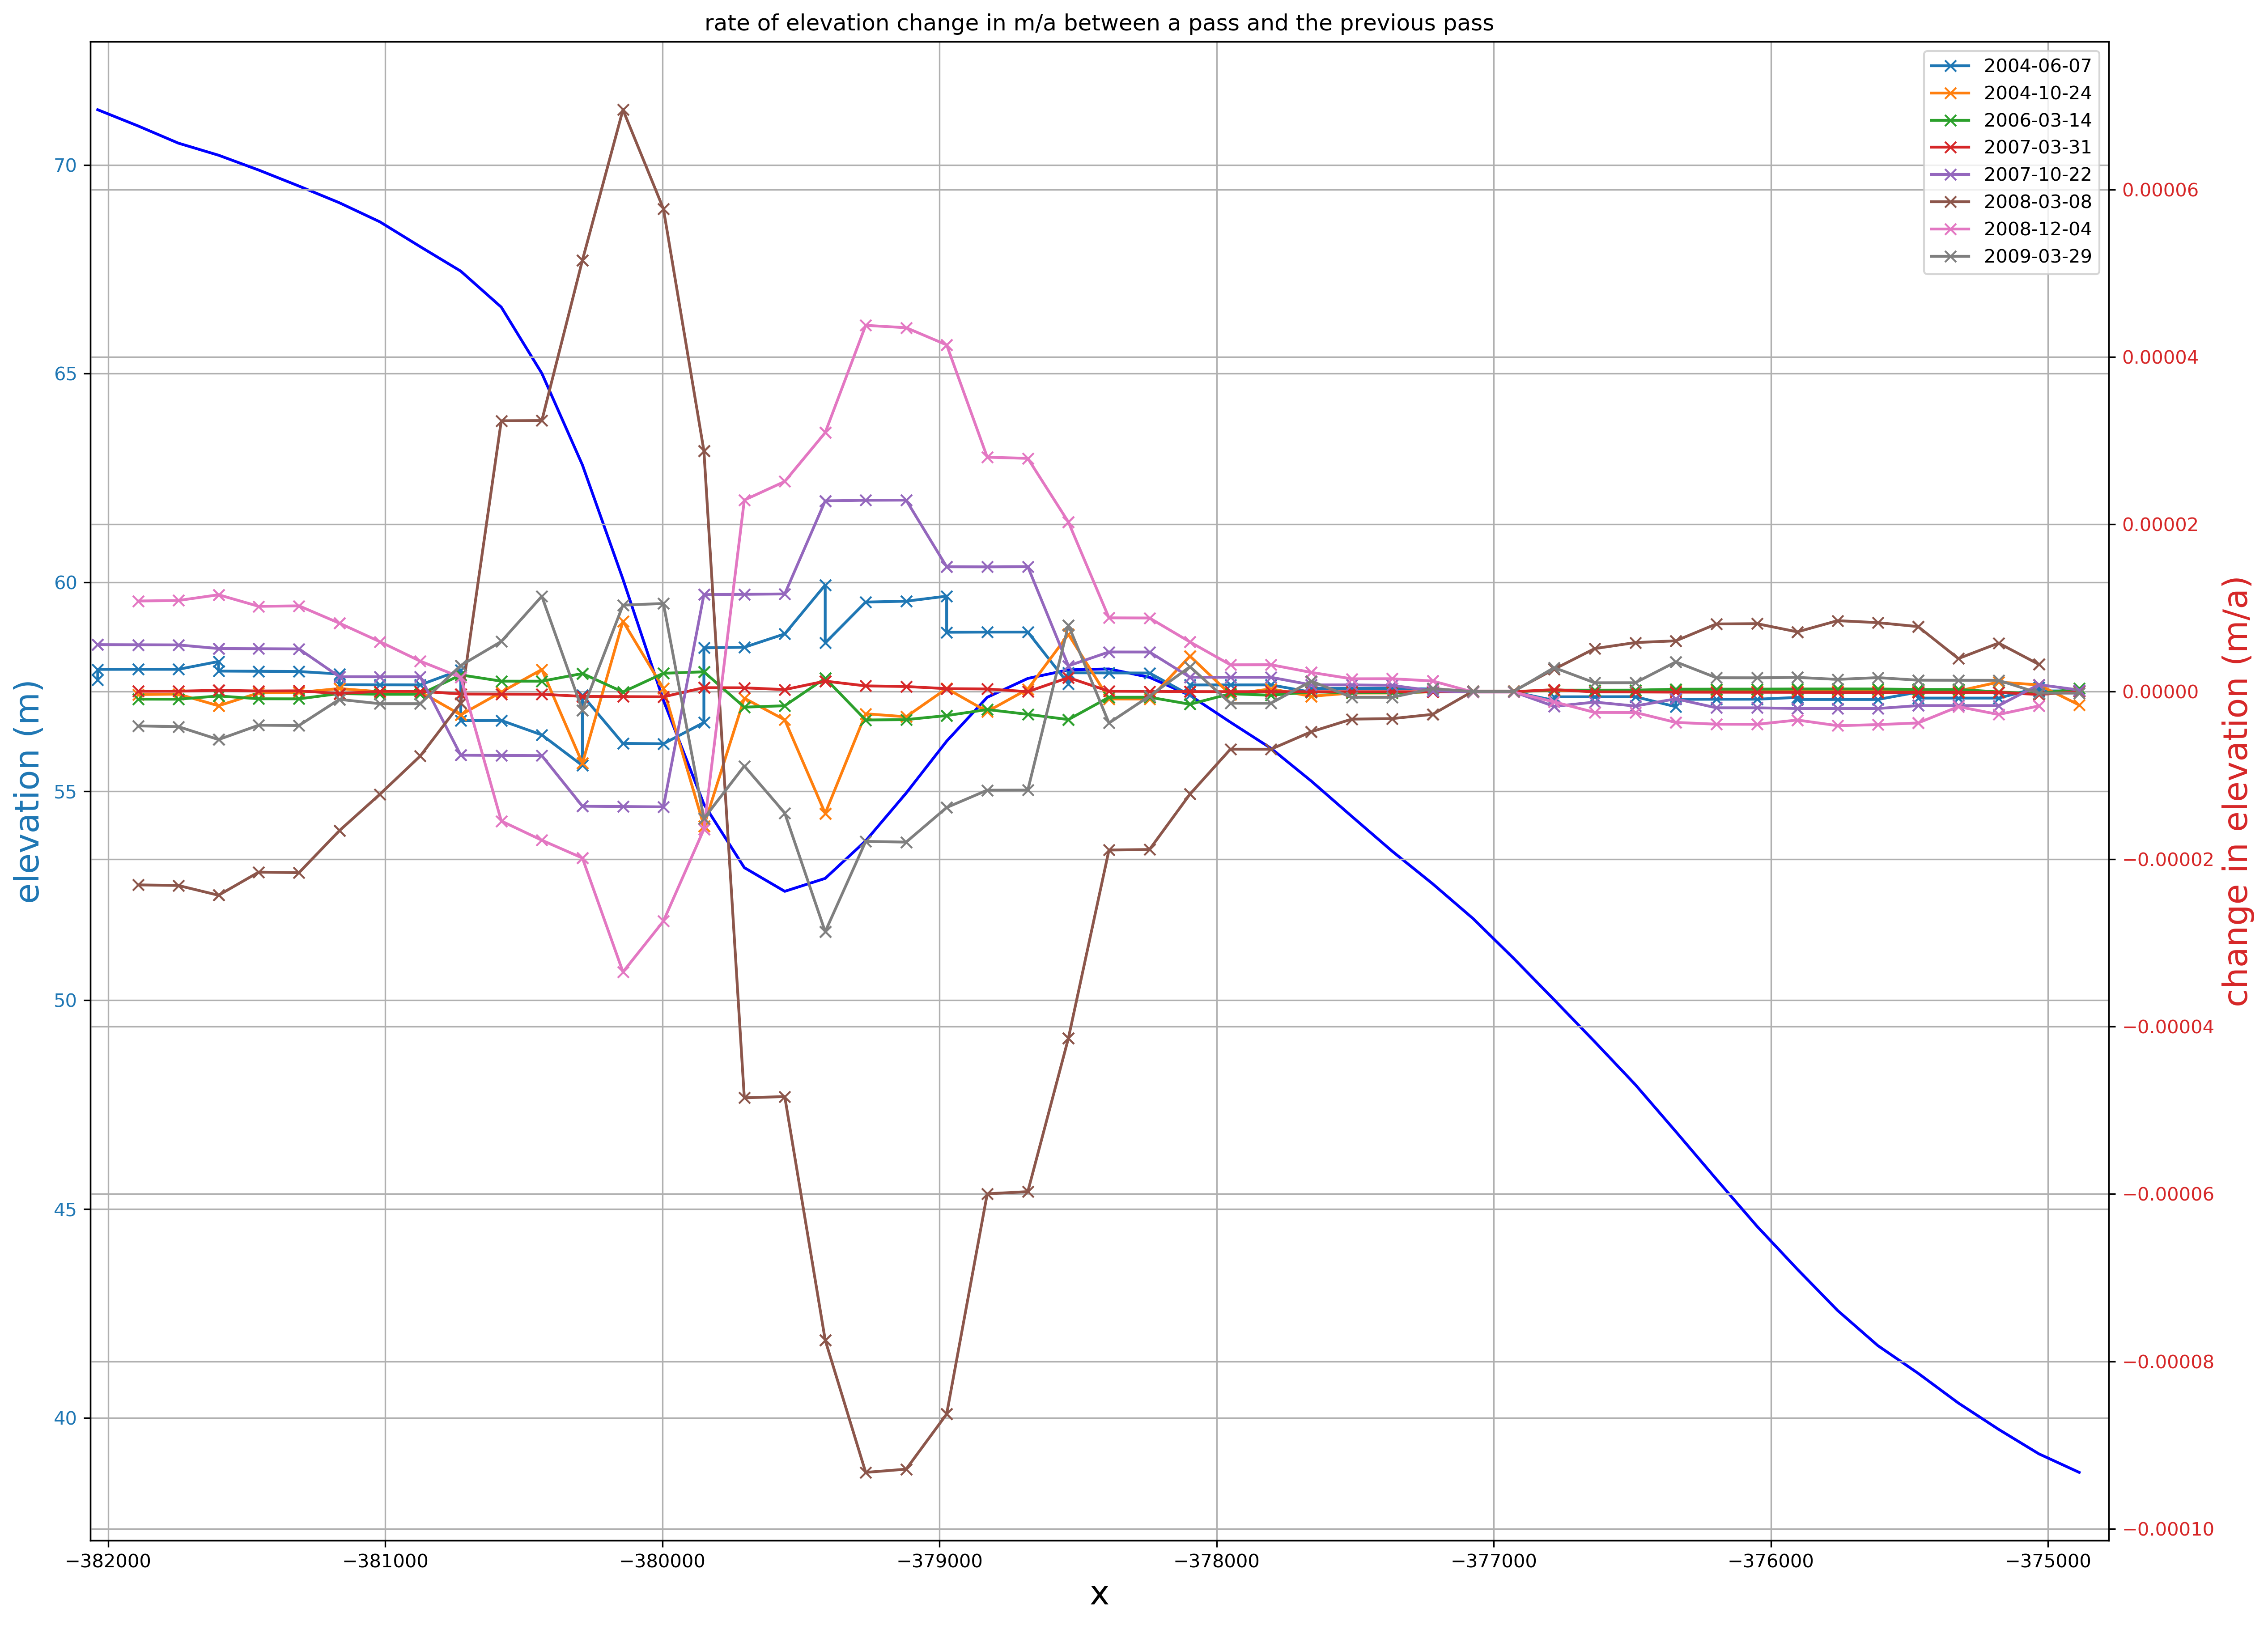

In [64]:
plot_dzdt_by_line(track = 'track0211',x_or_y='x')

# same for 0099

/Users/home/whitefar/miniconda3/envs/remote_sensing/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/home/whitefar/miniconda3/envs/remote_sensing/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in subtract


not enough data for 2004-10-16, only 16 points
not enough data for 2006-06-05, only 1 points


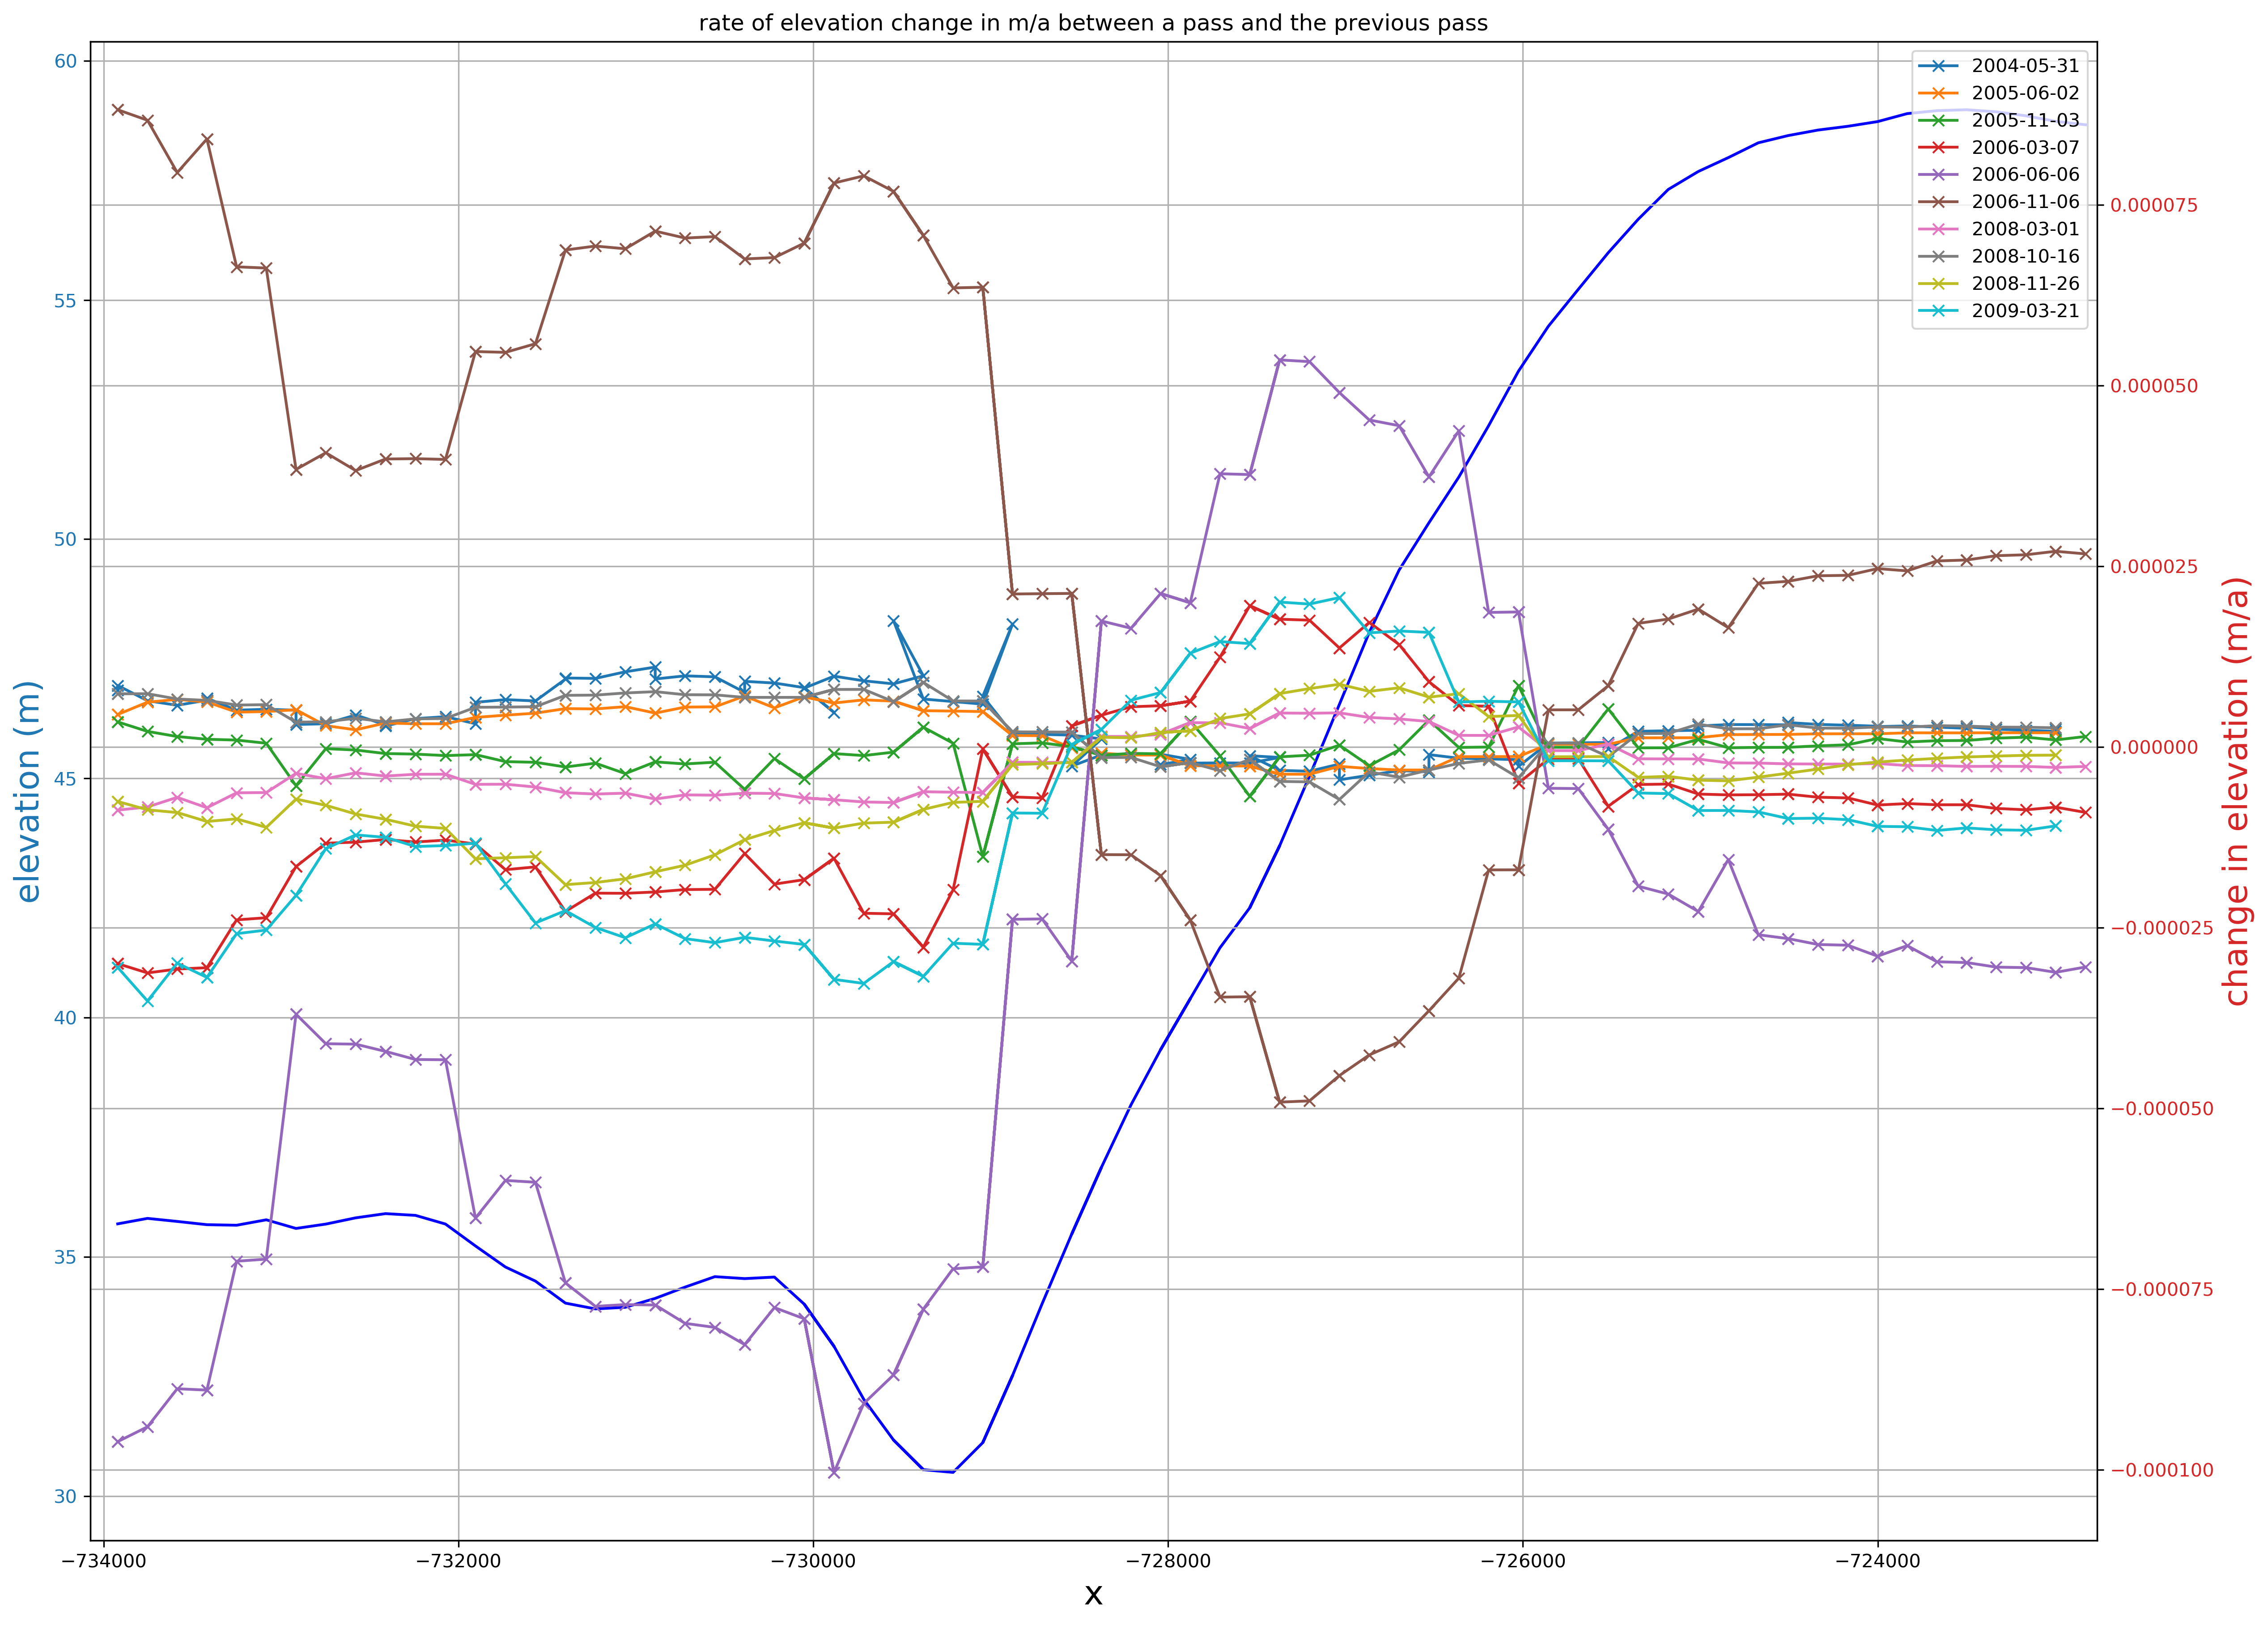

In [65]:
plot_dzdt_by_line(track = 'track0099',x_or_y='y')

# Interestingly
Where the rate changes from + to - is at the low. moving?

# working hypothesis, flexture

In [20]:
zp_t0.keys()

Index(['x', 'pass_num', 'y', 'bin_number', 'dzdt', 'elev_wgs84_tpxtide',
       'grad', 'ret', 'retide', 'sdatedays', 'z', 'UTCtime', 'timestamp', 'zp',
       'residual', 'dz', 'geometry'],
      dtype='object')

# cumulative rate

ie each line minus the first line


In [66]:
def plot_cumdzdt_by_line(track, x_or_y = 'x'):

    da = icesat1_load_alldzdt_pickle(track)

    zp_t0 = da[da.timestamp.dt.date==min(da.timestamp.dt.date.unique())].copy()

    dz_dts_rates = [] # change in elevation in m / y
    dates = []
    z_0 = zp_t0.zp.to_numpy() 
    date_0 = zp_t0.timestamp.dt.date.iloc[0]
    
    for pass_date in da.sort_values(['timestamp'],axis=0).timestamp.dt.date.unique()[1:]:

        da_date = da[da.timestamp.dt.date==pass_date].copy() #dataframe restricted to the area, restricted to a cetrain date
        if da_date.shape[0] < len(zp_t0[x_or_y]) - 5:            
            print(f'not enough data for {pass_date}, only {da_date.shape[0]} points')
            continue


        #interpolate so that we can
        f = interpolate.interp1d(da_date[x_or_y], da_date.zp,fill_value="extrapolate")
        z_1 = f(zp_t0[x_or_y])
        date_1 = pass_date

        dz_dts_rates.append( (z_1 - z_0 ) / (date_1 - date_0).days /365.2422 )
        dates.append( pass_date )
        del da_date
        
    fig, ax1 = plt.subplots(figsize=(17,12),dpi=300)
    color = 'tab:blue'
    ax1.set_xlabel('x',fontsize=18)
    ax1.set_ylabel('elevation (m)', color=color,fontsize=18)
    ax1.plot(zp_t0[x_or_y],zp_t0.z,'b-')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid()

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:red'
    ax2.set_ylabel('change in elevation (m/a)', color=color,fontsize=18)
    for date,dz_dt_rate in zip(dates,dz_dts_rates):
        ax2.plot(zp_t0[x_or_y],dz_dt_rate,'x-',label=date)
        if x_or_y == 'x':
            plt.xlim([-382064.5722209641,-374781.1654740692])
        elif x_or_y == 'y':
            plt.xlim([ -734075.0820404041,-722764.4514729496])
    plt.legend()
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.grid()

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title(f'cumulative rate of elevation change, m/a between each pass and the first pass')
    plt.show()


/Users/home/whitefar/miniconda3/envs/remote_sensing/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


not enough data for 2006-11-14, only 56 points
not enough data for 2009-03-21, only 7 points


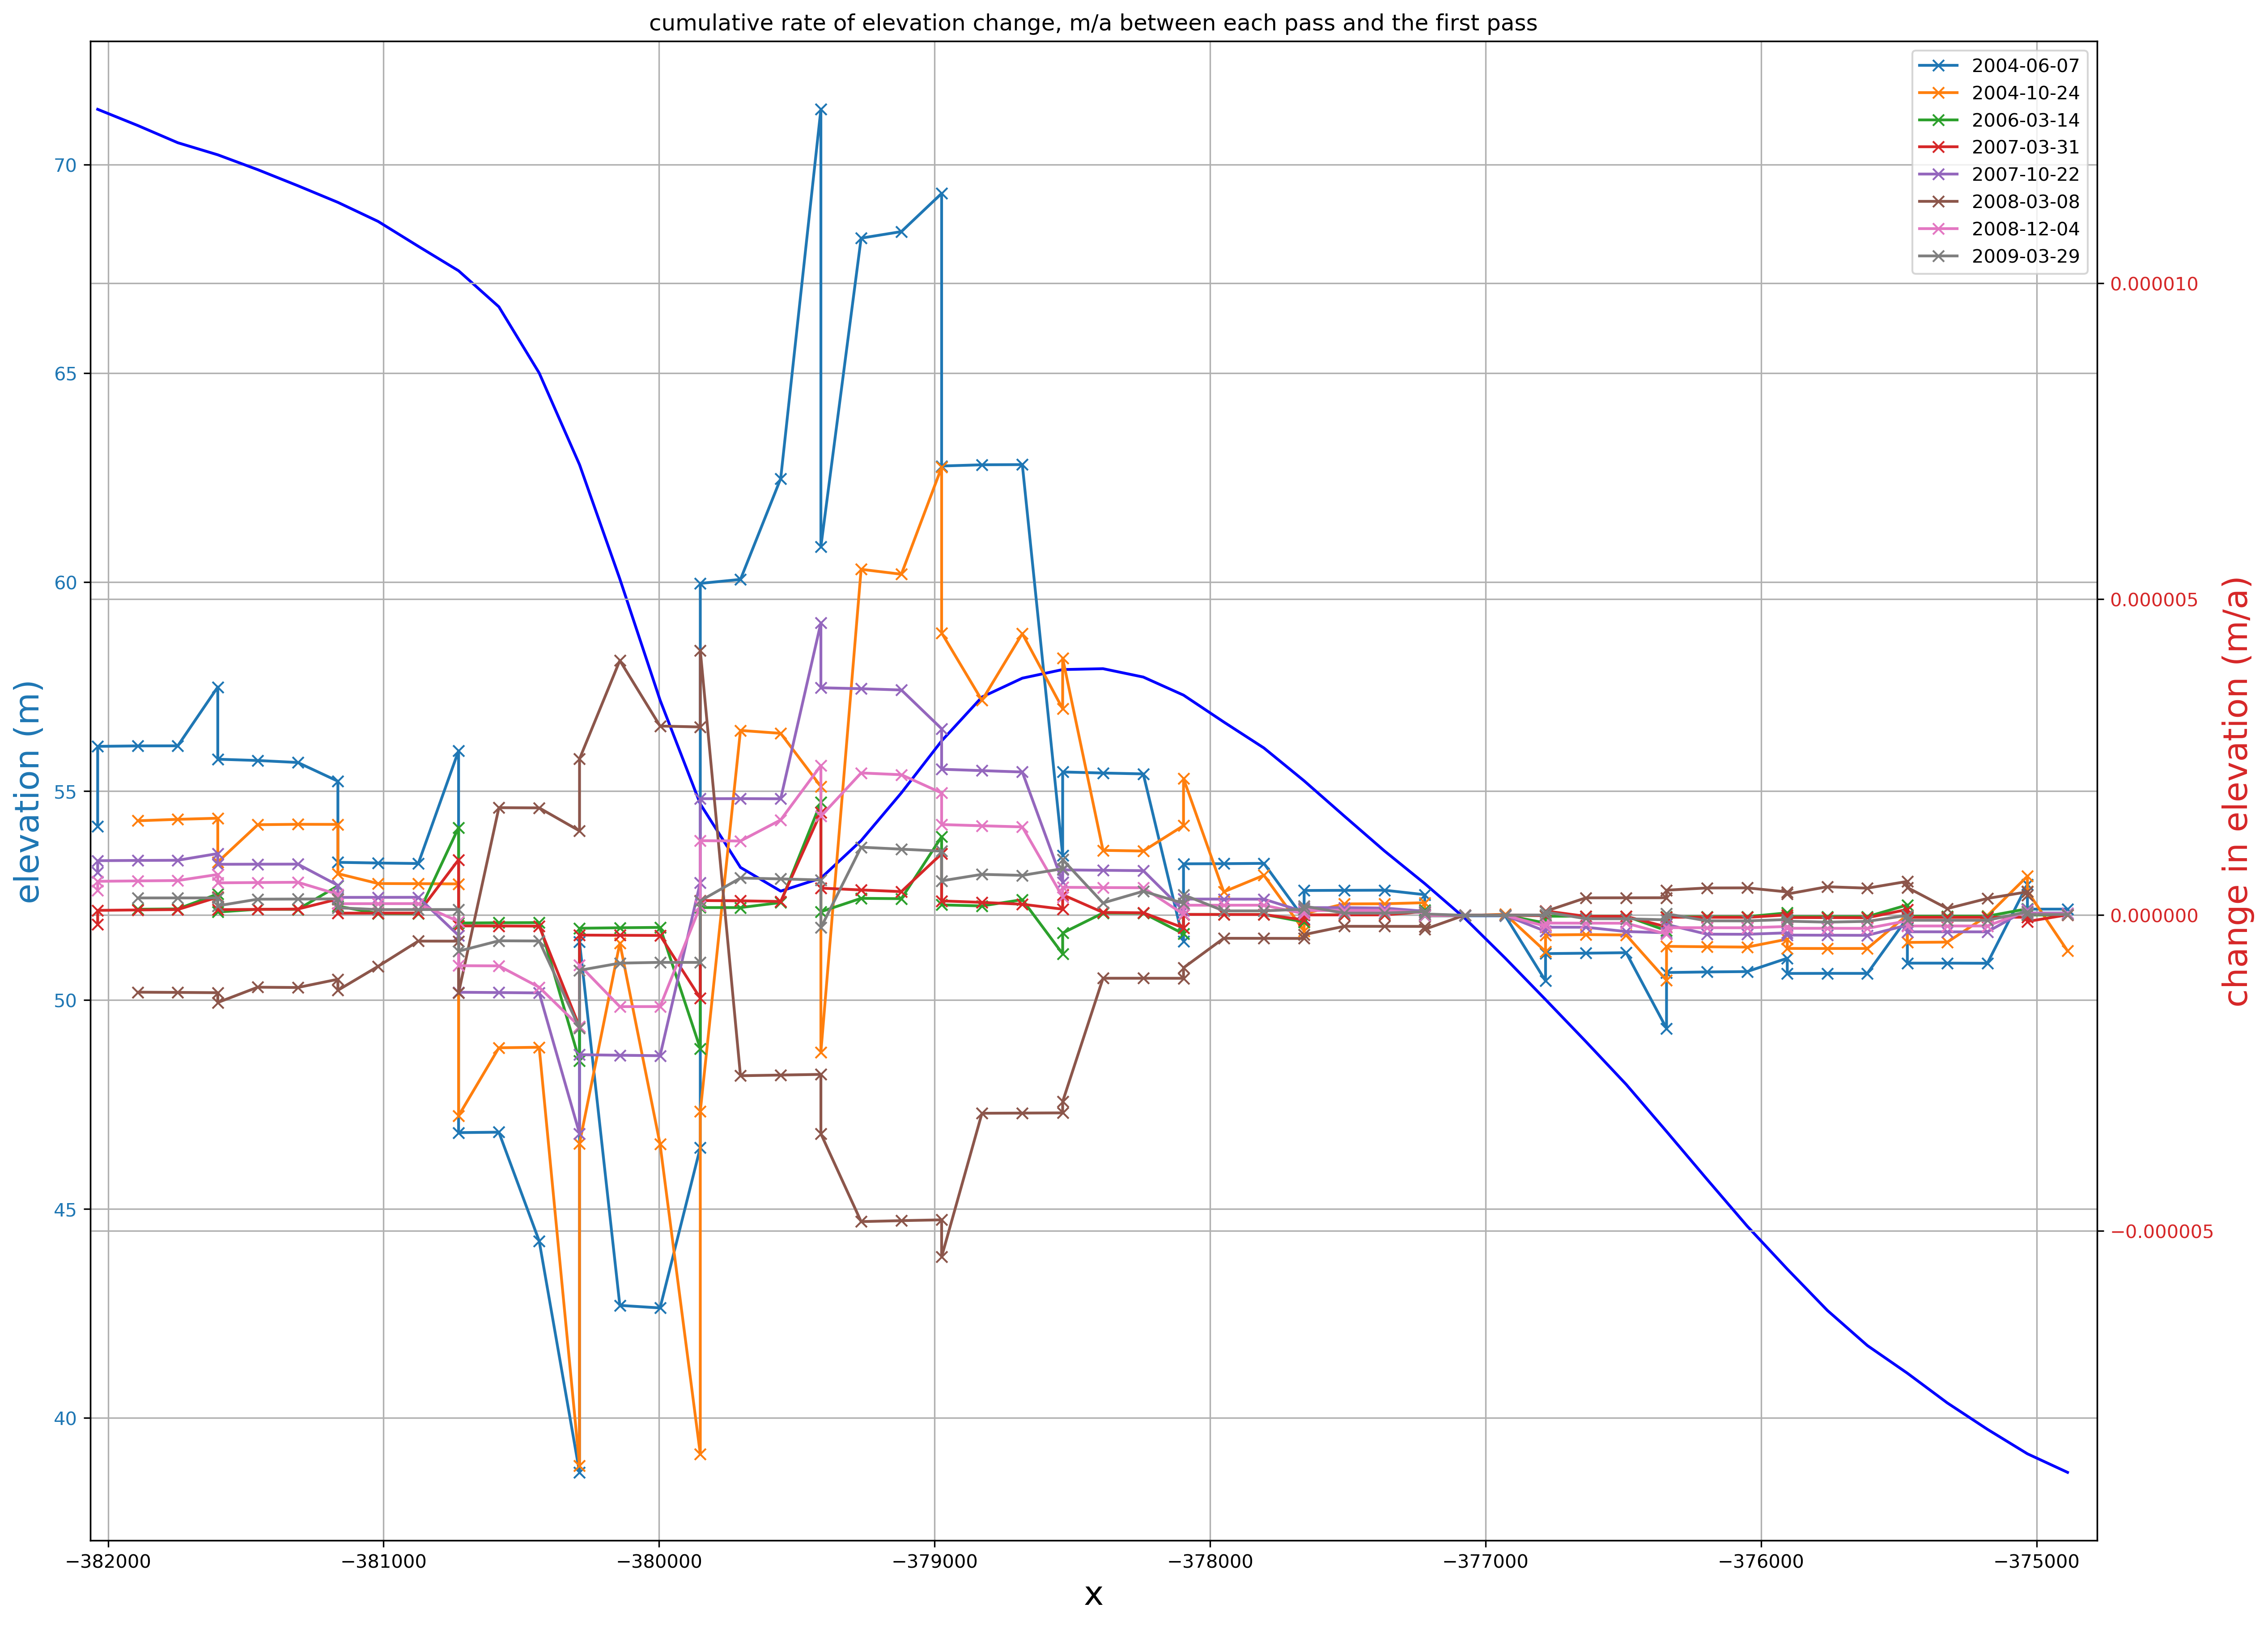

In [67]:
plot_cumdzdt_by_line(track = 'track0211',x_or_y='x')

/Users/home/whitefar/miniconda3/envs/remote_sensing/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


not enough data for 2004-10-16, only 16 points
not enough data for 2006-06-05, only 1 points


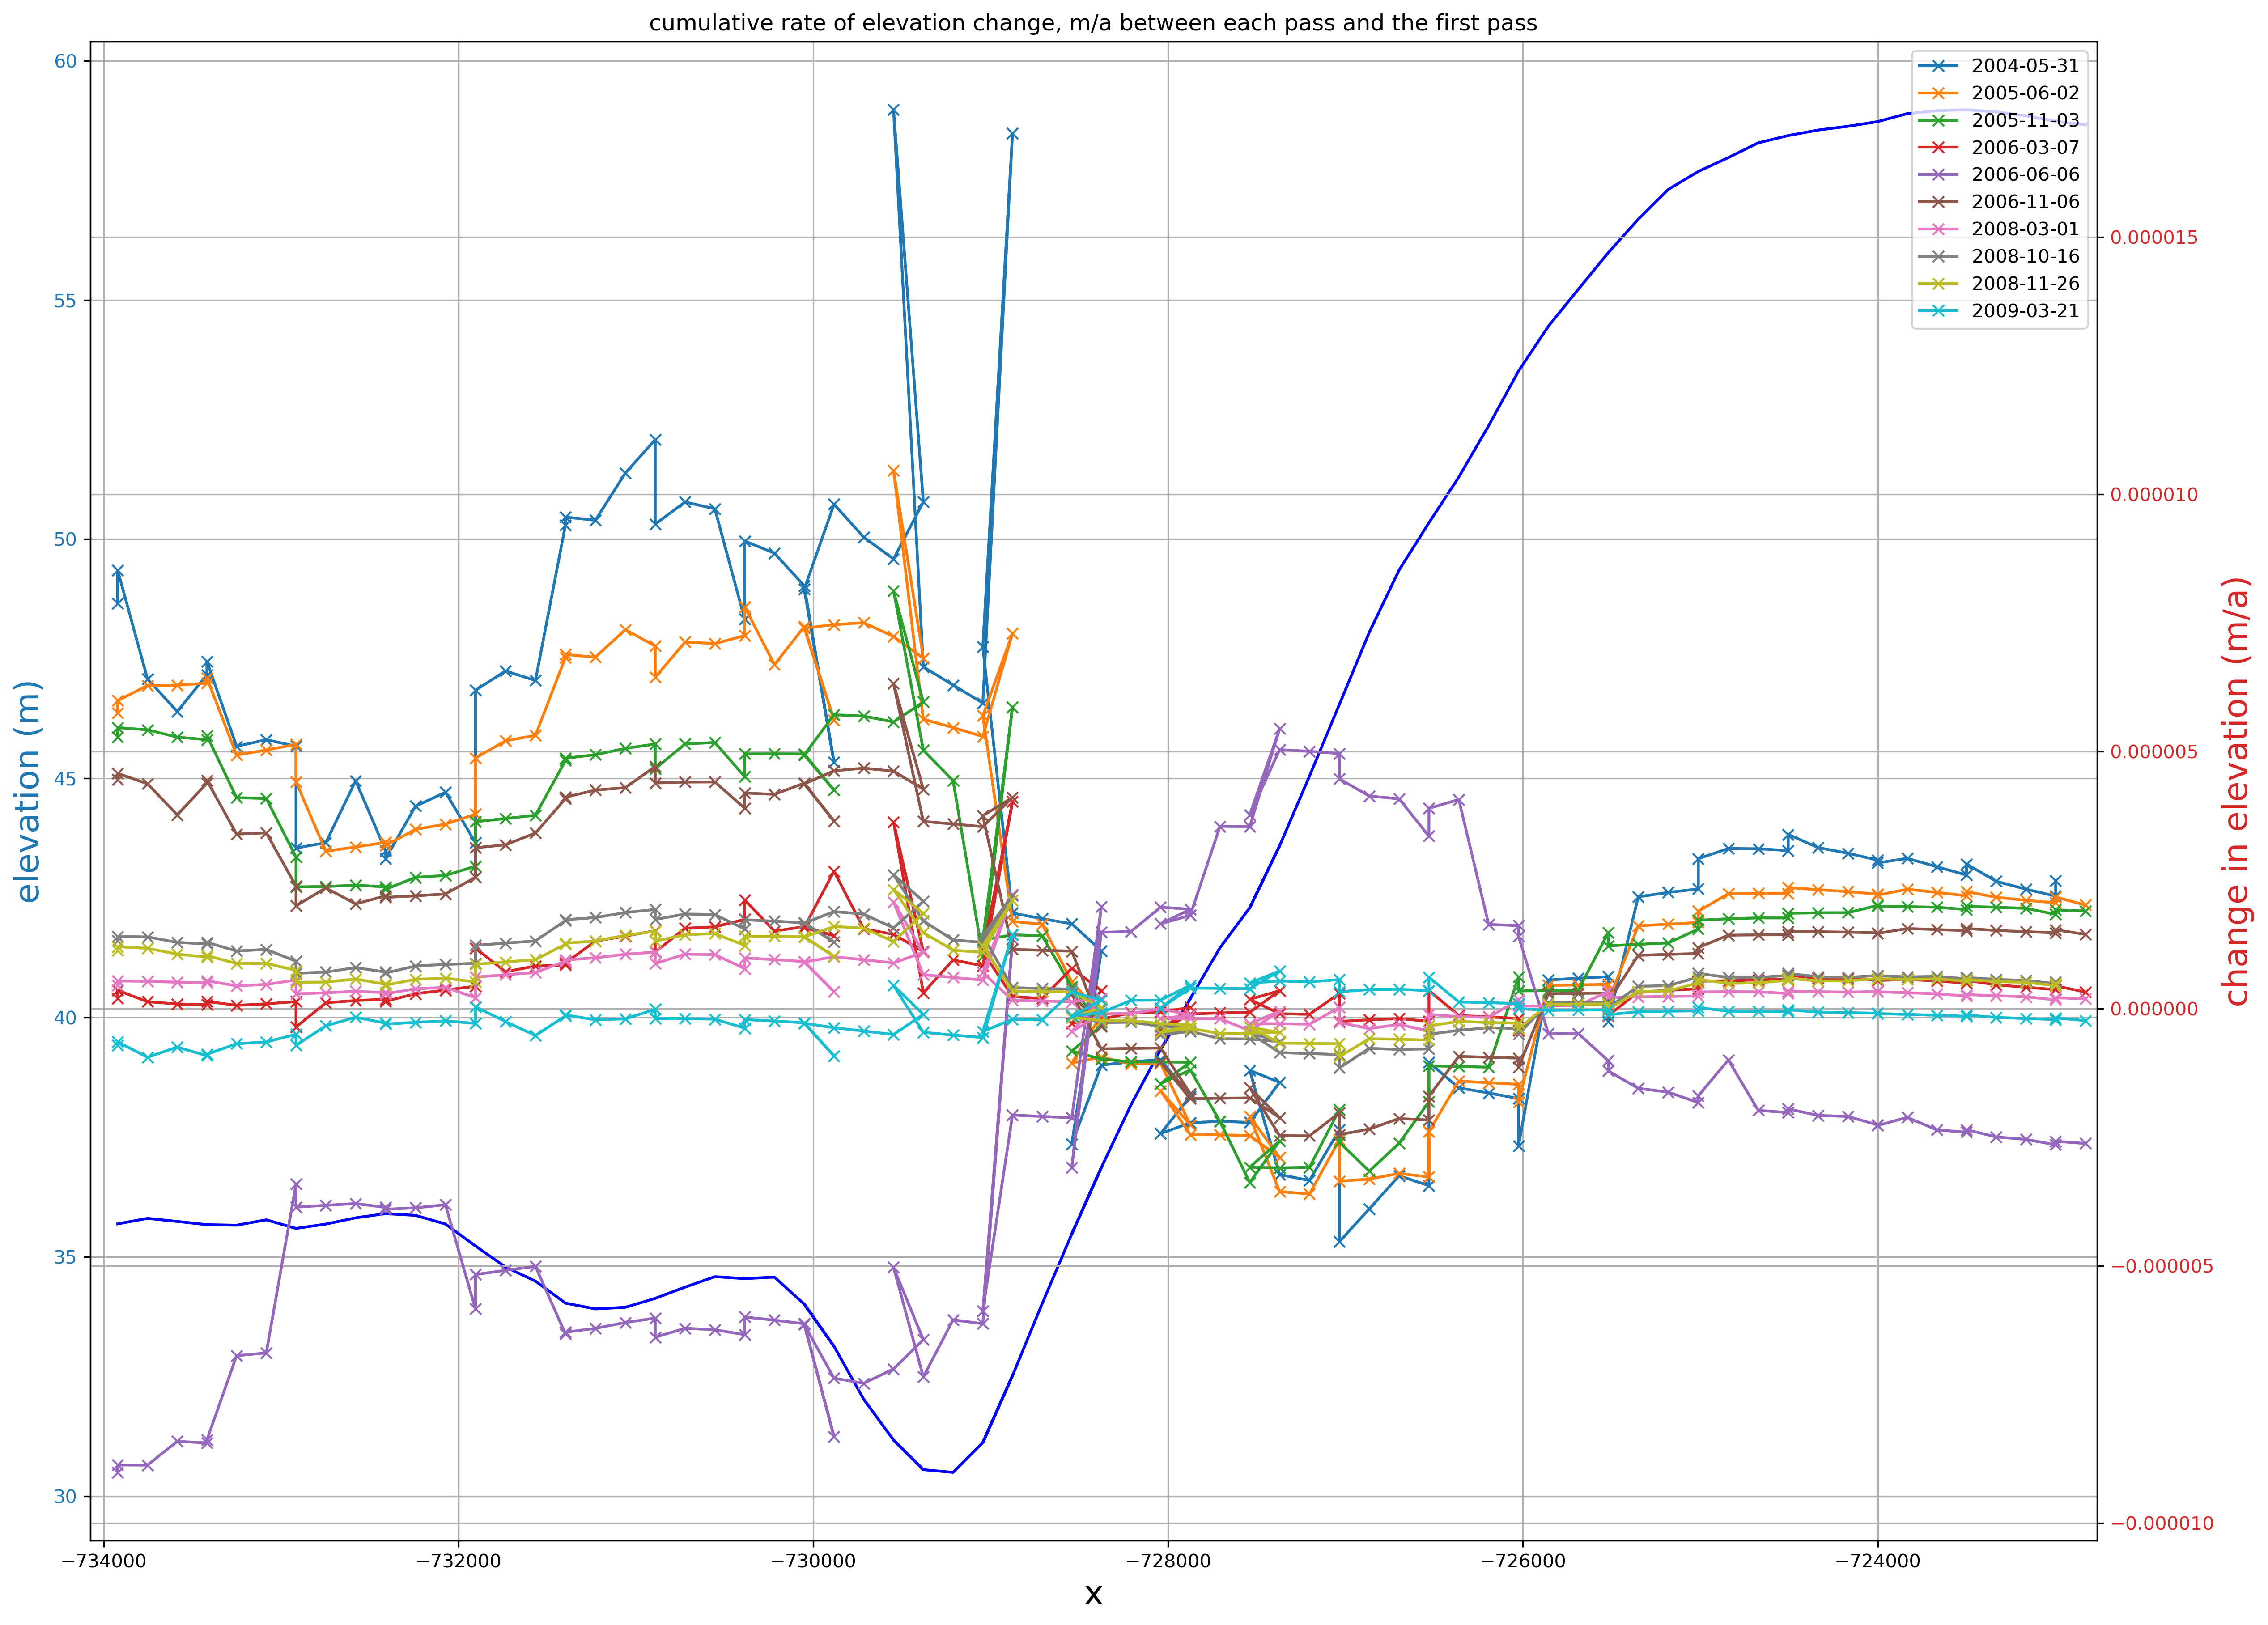

In [68]:
plot_cumdzdt_by_line(track = 'track0099',x_or_y='y')

# 